<a href="https://colab.research.google.com/github/AnupJoseph/Knowledge-Graph/blob/master/KnowlegeGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://archive.org/download/stackexchange/askubuntu.com.7z

In [0]:
!cp -r /content/drive/My\ Drive/stackoverflow/csvs /content/

In [0]:
!pip install textpipeliner

In [0]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline
nlp = spacy.load('en_core_web_sm')

In [73]:
posts = pd.read_csv("csvs/posts.csv")
posts_content = posts.body[:500]
posts_content.head()

0    <p>Every time I turn on my computer, I see a message saying something like:</p><pre><code>Your batte
1    <p>Maybe <a href=http://linux.aldeby.org/get-rid-of-your-battery-may-be-broken-notification.html>the
2    <p>How can I set the Software Center to allow non-root users to install stuff from the Ubuntu repos 
3    <p>What are some alternatives to upgrading without using the standard upgrade system? Suppose for ex
4    <p>I have a ubuntu development server at work. It is an old rack server that is located somewhere in
Name: body, dtype: object

In [0]:
import re
def html_cleaner(post):
    post = BeautifulSoup(post)
    for s in post(['script', 'style']):
        s.decompose()
    return ' '.join(post.stripped_strings)

In [0]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [0]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [77]:
entity_pairs = []

for post in tqdm(posts_content):
  post = html_cleaner(post)
  entity_pairs.append(get_entities(post))

entity_pairs[30:40]


100%|██████████| 500/500 [00:05<00:00, 83.62it/s]


[['exim4 machine name', 'exim4  MTA'],
 ['just update you', 'c'],
 ['you', 'directly  LTS'],
 ['initial gnome panel', 'mo'],
 ['simplest  way', 'commandline'],
 ['who', 's'],
 ['taskselsudo tasksel', 'lamp server'],
 ['many plug I', 'many plug ins'],
 ['which', 'x11vnc'],
 ['I', 'this']]

In [78]:
relations = [get_relation(i) for i in tqdm(posts_content)]


100%|██████████| 500/500 [00:05<00:00, 85.89it/s]


In [0]:
from collections import Counter
Counter(relations)

In [0]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [0]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

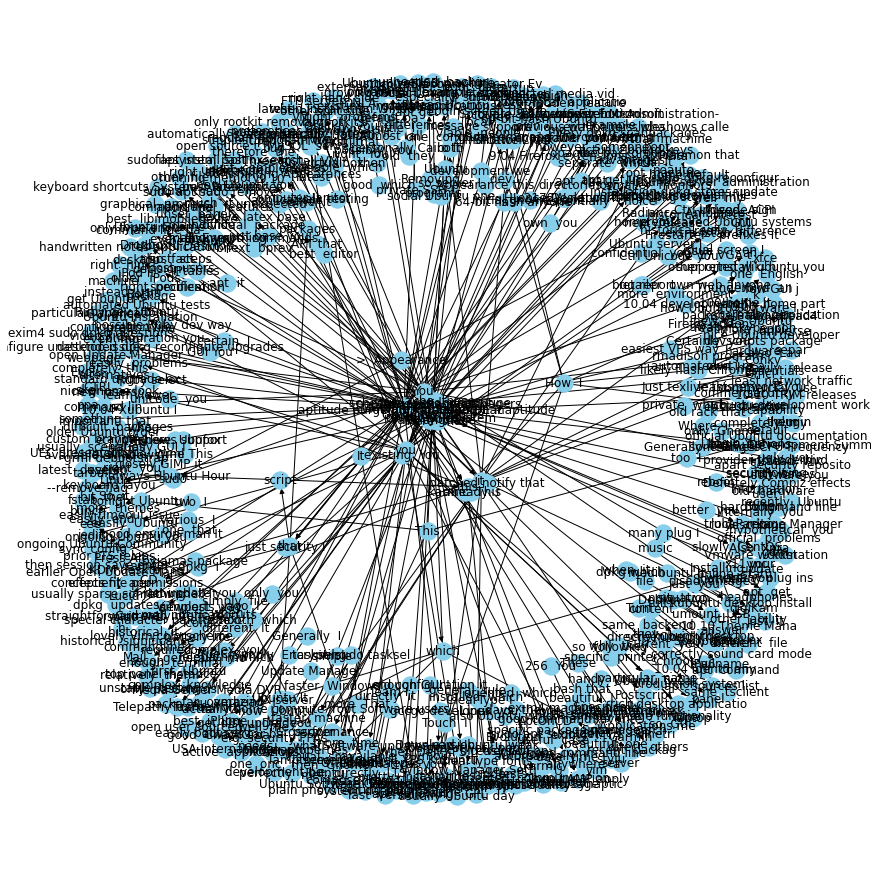

In [81]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

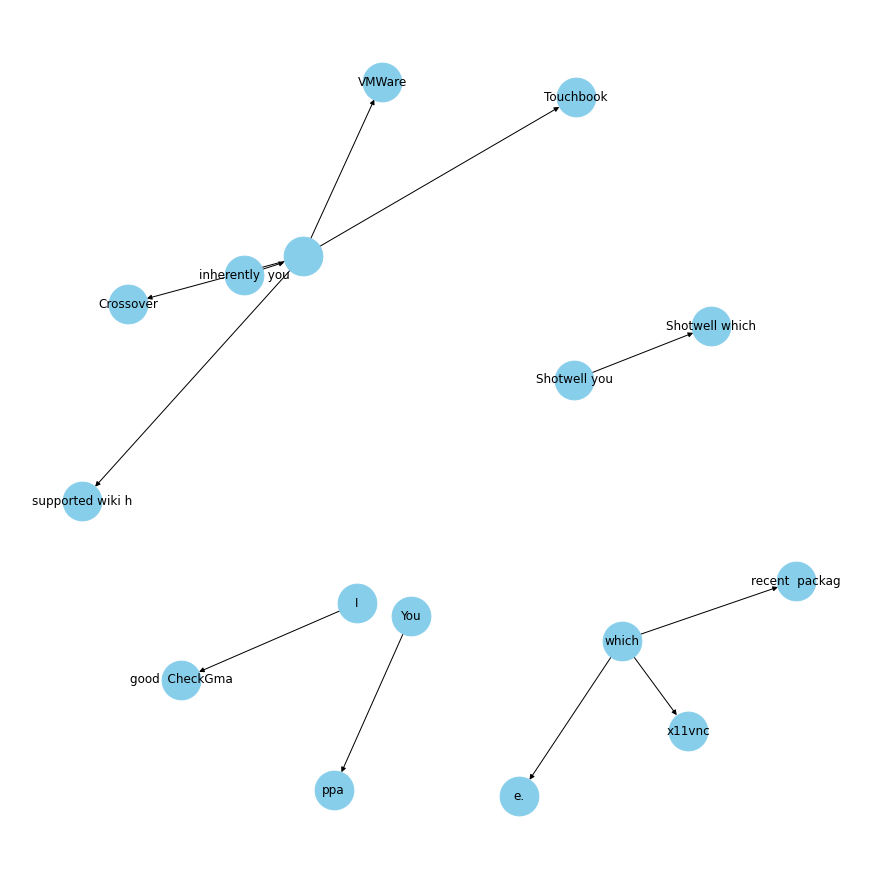

In [88]:

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="nofollow"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()